# Обработка стали

**Цель:**

Построить модель, которая предсказывает температуру стали.

**Описания процесса:**

Обработка стали производится в металлическом ковше, облицованном огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитоыми электродами. Они установлены в крышке ковша.

Из сплава выводтся сера (десульфация), добавлением примесей корректируется химичесий состав и отбираются пробы. Сталь легируют, подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат.

Перед первым вводом легирующих добавок имеряется температура стали и производится ее химический анализ. Потом температуру на неколько минут повышают, добавляют легирующие материалы и продувают сплав инетрным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

В конце процесса расплавленная сталь отправляется на доводку металла и поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок.

**Описание данных:**

Данные состоят из файлов, полученных из разных источников:
- data_arc.csv — данные об электродах;
- data_bulk.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time.csv — данные о подаче сыпучих материалов (время);
- data_gas.csv — данные о продувке сплава газом;
- data_temp.csv — результаты измерения температуры;
- data_wire.csv — данные о проволочных материалах (объём);
- data_wire_time.csv — данные о проволочных материалах (время).
Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

**Дополнительные условия:**

Из-за особенностей сбора информации с датчиков, в качестве признаков нельзя использовать промежуточные значения температуры. Только начальную.

In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor
from catboost import Pool


import warnings
warnings.filterwarnings('ignore')

# 1. Изучение данных

Посмотрим, что представляют из себя предоставленные данные.

Напишем функцию, которая открывает файл и выводит описание данных.

In [129]:
def read_describe(file_name):
    path = "D:\datasets\steel_processing\\"
    df = pd.read_csv(path + file_name)
    display(df.head())
    display(df.info())
    display(df.describe())
    
    return df

### Электроды

In [130]:
df_arc = read_describe('data_arc.csv')

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


В этой таблице следует привести два столбца к типу datetime.

In [131]:
df_arc['Начало нагрева дугой'] = pd.to_datetime(df_arc['Начало нагрева дугой'])
df_arc['Конец нагрева дугой'] = pd.to_datetime(df_arc['Конец нагрева дугой'])
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


Посмотрим на распределение показателей активной и реактивной мощности.

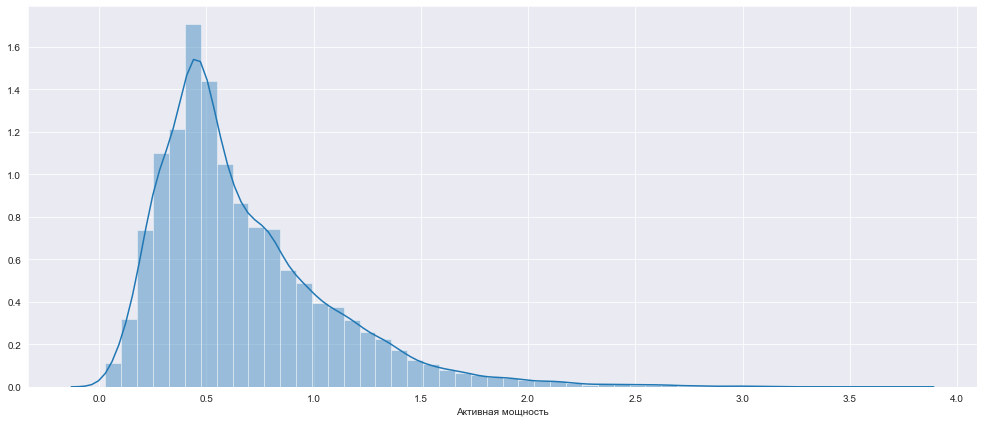

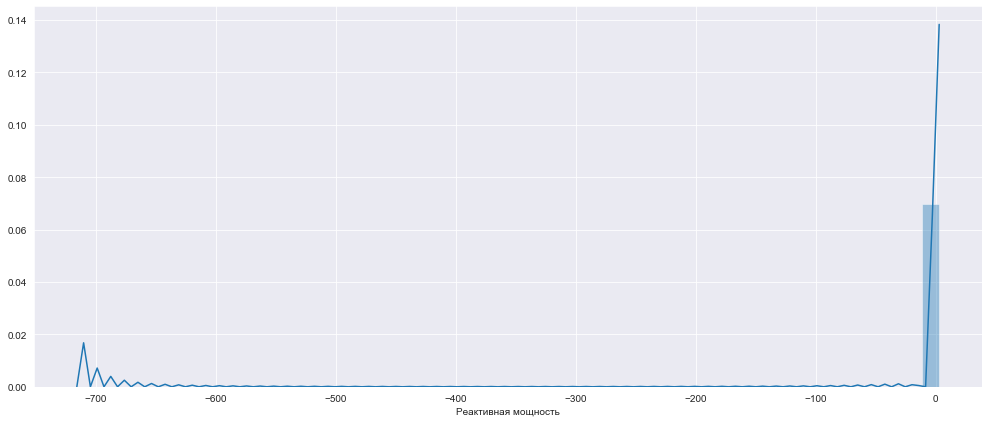

In [132]:
for column in df_arc.loc[:,'Активная мощность':].columns:
    plt.figure(figsize=(17, 7))
    sns.distplot(df_arc[column])
    plt.show()

Распределение активной мощности нормальное, скошенное право. Распределение реактивной мощности собрано вокруг нуля и есть пик на -700. Посмотрим на боксплот.

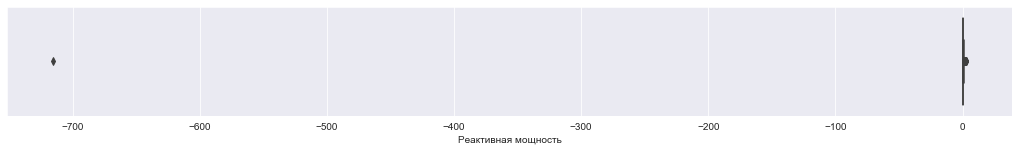

In [133]:
plt.figure(figsize=(18,2))
sns.color_palette()
sns.boxplot(df_arc['Реактивная мощность'])

Есть один выброс в районе -700. Увеличим масштаб.

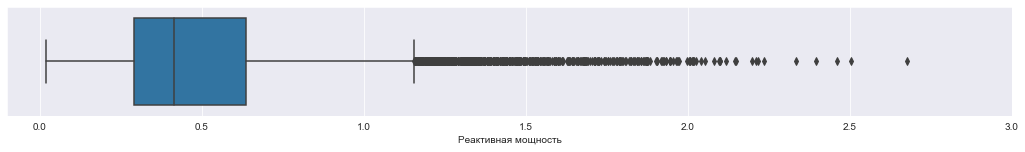

In [134]:
plt.figure(figsize=(18,2))
sns.boxplot(df_arc['Реактивная мощность'])
plt.xlim(-0.1,3);

Единичное большое отрицательное значение реактивной мощности - явно выброс. Остальные значения положительные и не превышают 3. Оставим в выборке только положительные значения реактвиной мощности.

In [135]:
df_arc = df_arc[df_arc['Реактивная мощность'] > 0]

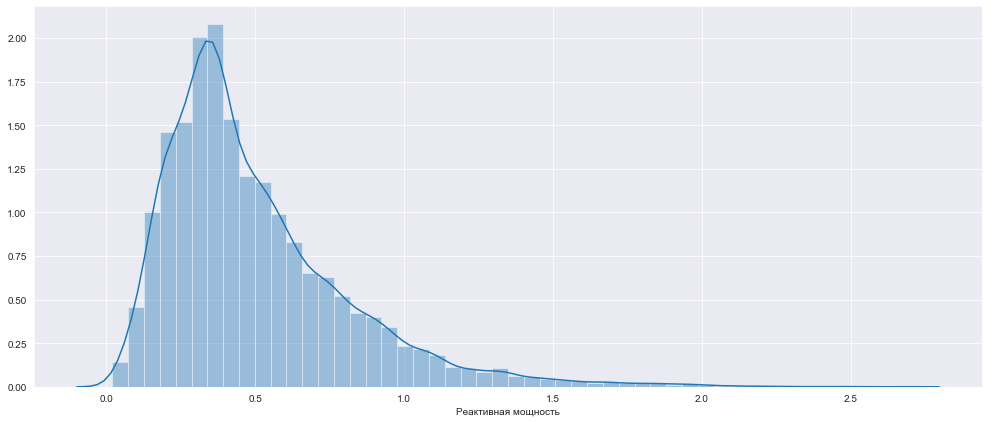

In [136]:
plt.figure(figsize=(17, 7))
sns.distplot(df_arc['Реактивная мощность'])

### Подача сыпчих метриалов (объем)

In [137]:
df_bulk = read_describe('data_bulk.csv')

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


В таблице присутствуют пропуски. Они означают отсутствие подачи легирующих добавок. При формировании признаков заменим их нулями.

### Подача сыпучих материалов (время)

In [138]:
df_bulk_time = read_describe('data_bulk_time.csv')

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


В этой таблице заменим тип данных на datetime. 

In [139]:
for column in df_bulk_time.columns[1:]:
    df_bulk_time[column] = pd.to_datetime(df_bulk_time[column])

df_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


Эта таблица аналогична предыдущей. Только здесь указано время ввода добавок. Скорее всего эта таблица нам не понадобится.

### Продувка газом

In [140]:
df_gas = read_describe('data_gas.csv')

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


### Измерение температуры

In [141]:
df_temp = read_describe('data_temp.csv')

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Приведем столбец время замера к типу datetime.

In [142]:
df_temp['Время замера'] = pd.to_datetime(df_temp['Время замера'])
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


Распределение значений температуры по всей выборке

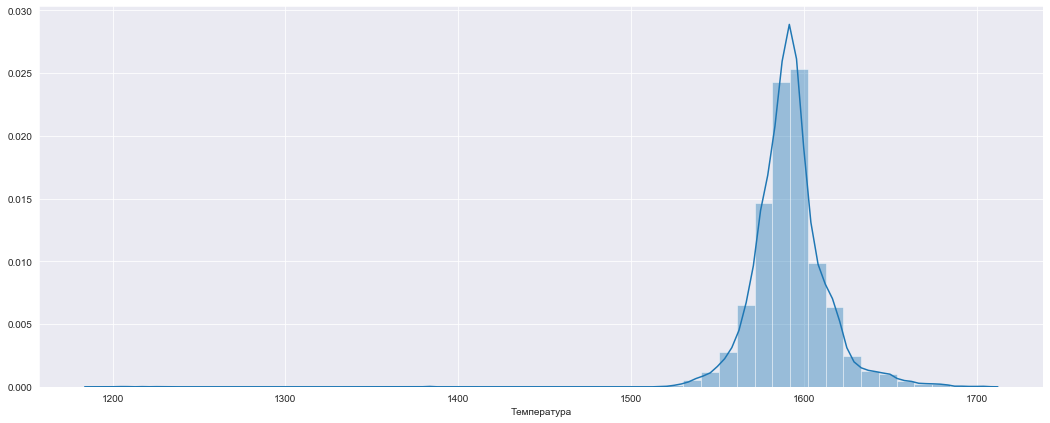

In [143]:
plt.figure(figsize=(18,7))
sns.distplot(df_temp['Температура']);

Распределение начальной и конечной темератур

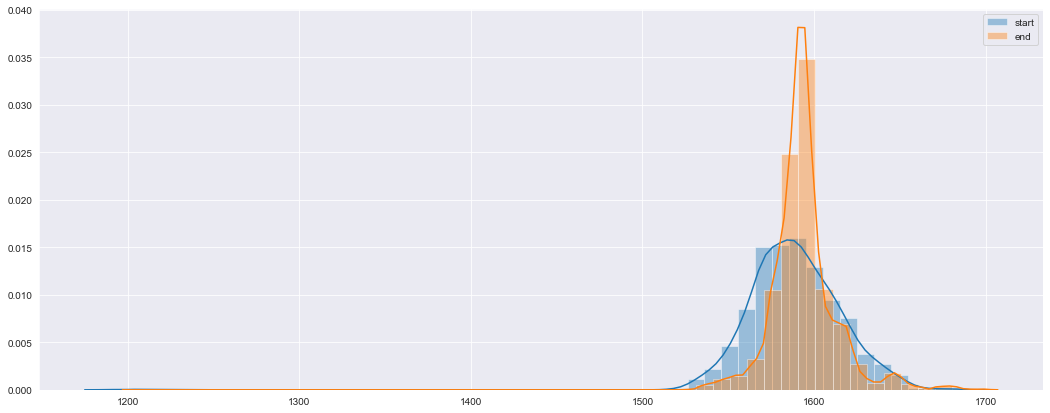

In [144]:
plt.figure(figsize=(18,7))
sns.distplot(df_temp.pivot_table(index='key', values='Температура', aggfunc='first'), label='start')
sns.distplot(df_temp.pivot_table(index='key', values='Температура', aggfunc='last'), label='end')
plt.legend();

Распределение температур нормальное. Диапазоны - в адекватных пределах.

В таблице присутствуют пропуски. Для формирования целевого признака нам необходима конечная температура для каждой партии. Если для отдельных ключей отсутствует температура в конце процесса - мы не сможем проверить корректность предсказаний модели.

Заменим пропущенные значения на нули. В дальнейшем по этим флаговым нулям удалим партии без конечной темпратуры.

In [145]:
df_temp = df_temp.fillna(0)
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   15907 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


### Проволочные материалы (объем)

In [146]:
df_wire = read_describe('data_wire.csv')

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


### Проволочные материалы (время)

In [147]:
df_wire_time = read_describe('data_wire_time.csv')

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Из предоставленных таблиц наибольший интерес представляют таблицы с информацией о нагреве электродов, температурами процесса и объемами легирующих добавок.

Из таблиц удалены одиночные явные выбросы. В остальном, показатели находятся в допустимых пределах.

В таблице с температурой для некоторых партий отсутствует конечная температура. Делать прогнозы для таких партий не получится. При формировании признаков удалим эти партии. На текущем этапе пропуски заменены нулями. 

# Подготовка признаков

Целевым признаком является температура в конце процесса.

### Признаки:

Основным признаком будет начальная температура.

На процесс нагрева влияют мощность и длительность нагрева. Из таблицы с температурой видно, что между нагревами происходит охлаждение заготовок, поэтому добавим время между нагревами.

Добавим также соотношение активной и реактивной мощности. Ввод легирующих добавок также может влияеть на конечную температуру, поэтому к таблице признаков добавим объемы добавок.

Для начала сформируем датафрейм с номерами ключей от 1 до 3414.

In [148]:
features = pd.DataFrame(index=(x for x in range(1,3242)))
features['key'] = features.index
features.head()

,key
1,1
2,2
3,3
4,4
5,5


Добавим в таблицу начальную и конечную температуры.

In [149]:
features['init_temp'] = df_temp.pivot_table(index='key', values='Температура', aggfunc='first')
features['end_temp'] = df_temp.pivot_table(index='key', values='Температура', aggfunc='last')
features.head()

,key,init_temp,end_temp
1,1,1571.0,1613.0
2,2,1581.0,1602.0
3,3,1596.0,1599.0
4,4,1601.0,1625.0
5,5,1576.0,1602.0


Удалим из таблицы партии с нулевой конечной температурой.

In [150]:
features = features[features['end_temp'] != 0]

Для учета естественного охлаждения добавим в признаки суммарное время между нагревами электродов.

df_arc.loc[df_arc['key'] == 1]['Время перед нагревом'] = (df_arc.loc[df_arc['key'] == 1]['Начало нагрева дугой'] -
                                                      df_arc.loc[df_arc['key'] == 1]['Конец нагрева дугой'].shift(1))
df_arc.head()

Добавим признак "длительность нагрева".

In [151]:
df_arc['Длительность нагрева'] = (df_arc['Конец нагрева дугой'] - df_arc['Начало нагрева дугой']).dt.seconds

Для учета затраченной энергии на нагрев сформируем признак рабта (произведение активной мощности и времени нагрева.

In [152]:
df_arc['act_work'] = df_arc['Активная мощность'] * df_arc['Длительность нагрева']

Вычислим суммарное время промежутков между нагревами и добавим в исходную таблицу.

In [153]:
%%time
keys = df_arc['key'].unique()
downtime = pd.Series()

for key in keys:
    temp_data = df_arc[df_arc['key'] == key]
    temp_data['last_time'] = temp_data['Конец нагрева дугой'].shift(1)
    temp_data['downtime'] = temp_data['Начало нагрева дугой'] - temp_data['last_time']
    temp_data['downtime'] = temp_data['downtime'].dt.seconds
    downtime = pd.concat([downtime, temp_data['downtime']])
    
df_arc['downtime'] = downtime 

Wall time: 7.8 s


In [154]:
df_arc['downtime'] = downtime
df_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Длительность нагрева,act_work,downtime
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228,222.541395,NaN
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185,149.037310,86.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172,128.030509,71.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365,605.667332,218.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148,102.527702,110.0
...,...,...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,157,83.786125,NaN
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,180,121.788672,209.0
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,184,135.037503,517.0
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,57,12.579555,726.0


Добавим в таблицу признаков работу работы активной мощности и время между нагревами.

In [155]:
features['act_work'] = df_arc.groupby('key')['act_work'].sum()
features['downtime'] = df_arc.groupby('key')['downtime'].sum()

Добавим в таблицу признаков средневзвешенное соотношение активной и реактивной мощности.

In [156]:
df_arc['power_ratio'] = df_arc['Активная мощность'] / df_arc['Реактивная мощность']
df_arc['power_ratio'] = df_arc['power_ratio'] * df_arc['Длительность нагрева']

features['power_ratio'] = (df_arc.groupby('key')[['power_ratio']].sum()
                          .rename(columns={'Отношение мощностей': 'Среднее отношение мощностей'}))

features['power_ratio'] /= df_arc.groupby('key')['Длительность нагрева'].sum()

In [157]:
features.head()

,key,init_temp,end_temp,act_work,downtime,power_ratio
1,1,1571.0,1613.0,1207.804249,485.0,1.534047
2,2,1581.0,1602.0,733.816470,333.0,1.530791
3,3,1596.0,1599.0,443.583327,870.0,1.579815
4,4,1601.0,1625.0,670.663327,352.0,1.561254
5,5,1576.0,1602.0,997.496095,493.0,1.488775


Добавляем к признакам объемы легирующих добавок:

In [158]:
features

,key,init_temp,end_temp,act_work,downtime,power_ratio
1,1,1571.0,1613.0,1207.804249,485.0,1.534047
2,2,1581.0,1602.0,733.816470,333.0,1.530791
3,3,1596.0,1599.0,443.583327,870.0,1.579815
4,4,1601.0,1625.0,670.663327,352.0,1.561254
5,5,1576.0,1602.0,997.496095,493.0,1.488775
...,...,...,...,...,...,...
2498,2498,1591.0,1594.0,629.928649,608.0,1.448488
2499,2499,1569.0,1603.0,1075.132183,483.0,1.479151
2683,2683,NaN,NaN,NaN,NaN,NaN
3200,3200,NaN,NaN,NaN,NaN,NaN


In [159]:
features = features.merge(df_bulk, how='outer', on='key')
features = features.merge(df_wire, how='outer', on='key')
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3238 entries, 0 to 3237
Data columns (total 30 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          3238 non-null   int64  
 1   init_temp    2477 non-null   float64
 2   end_temp     2477 non-null   float64
 3   act_work     2475 non-null   float64
 4   downtime     2475 non-null   float64
 5   power_ratio  2475 non-null   float64
 6   Bulk 1       252 non-null    float64
 7   Bulk 2       22 non-null     float64
 8   Bulk 3       1298 non-null   float64
 9   Bulk 4       1014 non-null   float64
 10  Bulk 5       77 non-null     float64
 11  Bulk 6       576 non-null    float64
 12  Bulk 7       25 non-null     float64
 13  Bulk 8       1 non-null      float64
 14  Bulk 9       19 non-null     float64
 15  Bulk 10      176 non-null    float64
 16  Bulk 11      177 non-null    float64
 17  Bulk 12      2450 non-null   float64
 18  Bulk 13      18 non-null     float64
 19  Bulk 1

In [160]:
# Количество пропусков:
features['end_temp'].isnull().sum()

761

В таблице признаков присутствют пропуски. Пропуски в конечной температуре удалим. В признаках с легирующими добавками заменим пропуски нулями. А пропуски в остальных признаках удалим (их незначительное количество).

In [161]:
features = features.dropna(subset=['end_temp'])
features = features.dropna(subset=['act_work'])
features.loc[:,'Bulk 1':] = features.loc[:,'Bulk 1':].fillna(0)
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2498
Data columns (total 30 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          2475 non-null   int64  
 1   init_temp    2475 non-null   float64
 2   end_temp     2475 non-null   float64
 3   act_work     2475 non-null   float64
 4   downtime     2475 non-null   float64
 5   power_ratio  2475 non-null   float64
 6   Bulk 1       2475 non-null   float64
 7   Bulk 2       2475 non-null   float64
 8   Bulk 3       2475 non-null   float64
 9   Bulk 4       2475 non-null   float64
 10  Bulk 5       2475 non-null   float64
 11  Bulk 6       2475 non-null   float64
 12  Bulk 7       2475 non-null   float64
 13  Bulk 8       2475 non-null   float64
 14  Bulk 9       2475 non-null   float64
 15  Bulk 10      2475 non-null   float64
 16  Bulk 11      2475 non-null   float64
 17  Bulk 12      2475 non-null   float64
 18  Bulk 13      2475 non-null   float64
 19  Bulk 1

Сформируем таблицы целевых и обучающих признаков:

In [162]:
target = features[['end_temp']]

features = features.drop(['key', 'end_temp'], axis=1)

In [163]:
target.head()

,end_temp
0,1613.0
1,1602.0
2,1599.0
3,1625.0
4,1602.0


In [164]:
features.head()

,init_temp,act_work,downtime,power_ratio,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1571.0,1207.804249,485.0,1.534047,0.0,0.0,0.0,43.0,0.0,0.0,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1581.0,733.816470,333.0,1.530791,0.0,0.0,0.0,73.0,0.0,0.0,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1596.0,443.583327,870.0,1.579815,0.0,0.0,0.0,34.0,0.0,0.0,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1601.0,670.663327,352.0,1.561254,0.0,0.0,0.0,81.0,0.0,0.0,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1576.0,997.496095,493.0,1.488775,0.0,0.0,0.0,78.0,0.0,0.0,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Создадим тестовую выборку. Поскольку объектов немного (чуть более 3000), тестовая выборка составит 10%.

In [165]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1, random_state=651)

In [178]:
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(2227, 28)
(2227, 1)
(248, 28)
(248, 1)


# Обучение моделей

Сравним несколько моделей.

**Случайный лес**

In [167]:
%%time

rf_params = {'max_depth': [10, 15, 20, 30, 40]}
rf = RandomForestRegressor(random_state=12)
model = GridSearchCV(estimator=rf,
             param_grid=rf_params,
             scoring='neg_mean_absolute_error',
             cv=5)
model.fit(features_train, target_train)

Wall time: 26.6 s


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=12,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [168]:
print('Лучшие параметры: {}'.format(model.best_params_))
print('MAE: {}'.format(model.best_score_))

Лучшие параметры: {'max_depth': 15}
MAE: -6.27466156967464


In [169]:
model.best_score_

-6.27466156967464

**Градиентный бустинг LightGBM.**

In [170]:
%%time

lgb = LGBMRegressor()
params_lgb = {'n_estimators' : [100, 200, 500],
              'max_depth' : [5, 15, 20, 50],
              'learning_rate' : [1, 0.1, 0.005, 0.001],
              }
lgb = GridSearchCV(estimator=lgb,
                   param_grid=params_lgb,
                   scoring='neg_mean_absolute_error',
                   cv=3)
lgb.fit(features_train, target_train)

Wall time: 29.7 s


GridSearchCV(cv=3, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [1, 0.1, 0.005, 0.001],
                         'max_depth': [5, 15, 20, 50],
                         'n_estimators': [100, 200, 500]},


In [171]:
print('МАЕ: {}'.format(lgb.best_score_))
print('Лучшие параметры: {}'.format(lgb.best_params_))

МАЕ: -6.219956076230113
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


**Градиентный бустинг из библиотеки CatBoost**

In [172]:
train_pool = Pool(data=features_train, label=target_train)
test_pool = Pool(data=features_test, label=target_test)
cb_model = CatBoostRegressor(iterations=4000, loss_function='MAE')
cb_model.fit(train_pool, eval_set=test_pool, plot=True, verbose=500)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 9.9336991	test: 8.8900796	best: 8.8900796 (0)	total: 3.65ms	remaining: 14.6s
500:	learn: 4.2273462	test: 5.8775591	best: 5.8744361 (474)	total: 2.08s	remaining: 14.5s
1000:	learn: 3.5703061	test: 5.7442432	best: 5.7427380 (970)	total: 3.95s	remaining: 11.8s
1500:	learn: 3.2342165	test: 5.7301147	best: 5.7227799 (1469)	total: 5.78s	remaining: 9.63s
2000:	learn: 3.0213068	test: 5.7213724	best: 5.7197430 (1980)	total: 7.63s	remaining: 7.62s
2500:	learn: 2.8700180	test: 5.7316173	best: 5.7175708 (2091)	total: 9.57s	remaining: 5.74s
3000:	learn: 2.7428165	test: 5.7307489	best: 5.7175708 (2091)	total: 11.5s	remaining: 3.82s
3500:	learn: 2.6479177	test: 5.7384018	best: 5.7175708 (2091)	total: 13.5s	remaining: 1.92s
3999:	learn: 2.5705311	test: 5.7283675	best: 5.7175708 (2091)	total: 15.5s	remaining: 0us

bestTest = 5.717570845
bestIteration = 2091

Shrink model to first 2092 iterations.


Лучший показатель на тестовой выборке показал градиентный бустинг CatBoost. МАЕ = 5.7.

# Анализ модели

Сформируем таблицу feature importance.

In [173]:
feature_importance = (pd.DataFrame(data=zip(features_train.columns, cb_model.feature_importances_),
                                  columns=['features', 'importance'])
                      .sort_values('importance', ascending=False))

In [174]:
feature_importance

,features,importance
0,init_temp,29.737993
1,act_work,22.091516
19,Wire 1,13.985994
2,downtime,5.801025
3,power_ratio,4.710089
9,Bulk 6,3.619808
17,Bulk 14,3.143719
15,Bulk 12,3.103367
4,Bulk 1,2.851319
20,Wire 2,2.757982


Визуализируем таблицу.

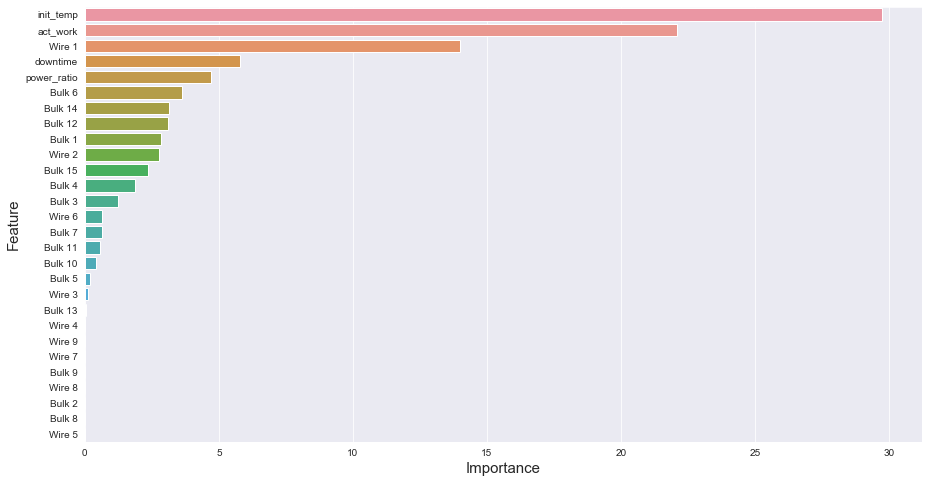

In [175]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x="importance", y="features", data=feature_importance)
ax.set_xlabel('Importance', fontsize=15)
ax.set_ylabel('Feature', fontsize=15)
ax.tick_params(labelsize=10)

Как видно из таблицы и графика, наибольшее влияние на обучение модели оказывает начальная температура. Учитывая, что ее значения превосходят значения остальных признаков, нормализация признаков только ухудшает качество модели.

Также к значимым факторам относятся работа нагрева, время простоя, а также ввод отдельных легирующих добавок.

# Выводы

1. Проведен анализ предоставленных данных для обучения модели. В исходных данных для некторых партий отсутствовала конечная температура. Такие партии не брались для обучения модели.
2. Проведена подготовка признаков. В их состав включены: начальная температура, работа активной мощности, суммарное время между нагревами, соотношение активной и реактивной мощности, объемы ввода легирующих добавок.
3. Для проверки модели сформирована тестовая выборка в размере 10% от исходной.
4. Проведено сравнение моделей линейной регресии, случайного леса из Sklearn и градиентного бустинга из библиотек LightGBM и CatBoost.
5. Лучшую точность показала модель градиентного бустинга от CatBoost. Среднее абсолютное отклонение на тестовой выборке составило 5.7.
6. Проведен анализ влияния признаков на точность прогноза. Наибольшую значимость имеет начальная температура и актиная мощность. Также сильное влияние оказывает ввод проволочного материала wire 1. Остальные легирующие добавки оказыват значительно меньшее влияние.